In [133]:
import torch
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## prepare input data

In [134]:
# filename = 'female_names.txt'
# filename = 'pokemon_names.txt'
filename = 'names.txt'

def get_names():
    names = []
    for line in open(filename, 'r'):
        if line.startswith('#'):
            continue
        name = line.strip().lower()
        if not name:
            continue
        if not name.isalpha():
            continue
        names.append(name)
    return names

In [135]:
import random 
names = get_names()

In [136]:
from typing import Tuple

letters = '.' + ''.join(sorted(set(''.join(names))))
num_letters = len(letters)

def index_2d_to_1d(ix1: int, ix2: int):
    return ix1 * num_letters + ix2

def index_1d_to_2d(ix: int) -> Tuple[int, int]:
    return ix // num_letters, ix % num_letters

itol = {i: l for i, l in enumerate(letters)}
ltoi = {l: i for i, l in enumerate(letters)}



In [137]:
itoll = {index_2d_to_1d(x, y): l1 + l2 for x, l1 in enumerate(letters) for y, l2 in enumerate(letters)}
lltoi = {l: i for i, l in itoll.items()}

In [138]:
print(letters)

assert 26 < len(letters) < 30
assert len(lltoi) == len(itoll)
assert lltoi[itoll[108]] == 108

assert index_1d_to_2d(index_2d_to_1d(4, 5)) == (4, 5)

.abcdefghijklmnopqrstuvwxyz


## Frequency based model

In [139]:
P = torch.ones((num_letters * num_letters, num_letters))

for word in names:
    word = ['.', '.'] + list(word) + ['.']
    for ch1, ch2, ch3 in zip(word, word[1:], word[2:]):
        ix1 = ltoi[ch1]
        ix2 = ltoi[ch2]
        ix3 = ltoi[ch3]

        P[index_2d_to_1d(ix1, ix2), ix3] += 1

P /= P.sum(1, keepdim=True)

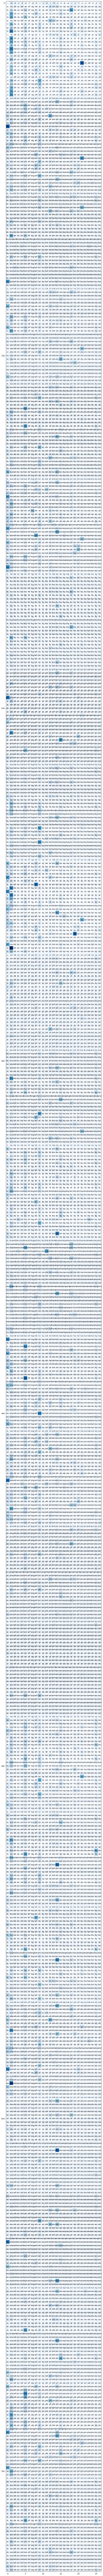

In [140]:
plt.figure(figsize=(32, 16 * 16))
plt.imshow(P, cmap='Blues')

for yy, row in enumerate(P):
    for x, val in enumerate(row):
        # plt.text(x, yy, f"{val:.2f}", va='center', ha='center')
        plt.text(x, yy, f"{itoll[yy] + itol[x]}", va='center', ha='center')

In [57]:
g = torch.Generator().manual_seed(2147483647)

for i in range(100):
    letters = '..'

    word = ''

    while True:
        ix = lltoi[letters]
        probs = P[ix]

        next_letter_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
        letter = itol[next_letter_ix.item()]

        if letter == '.':
            break

        word += letter
        letters = letters[1:] + letter
    print(word)

miq
axx
mereyannyaar
knooraen
el
marviovania
odarimalabelon
hamirelslen
elyn
rae
bra
ceevlainacelonikaireil
bech
amilleia
trutandennimsaby
crewina
lanoxvkyrina
khine
trise
koberseberryslot
ston
absdgcoraf
halinaelilik
khanv
erylo
zaehali
kayzlynnsondret
tasmaanourintin
midanleedes
denia
sabellee
domes
josahli
ezulinl
jasperabri
brea
ppqkgdla
dellucie
ne
sany
nasiah
izalyn
ah
leangsann
boytonik
evedamakore
tryn
can
an
antenceque
jas
ramairah
zip
alliviolunadie
tra
ikzsqpqeighnovern
hawandeny
garia
gra
ge
tabren
revonivetoppylany
rocougueliah
brelhane
da
marso
avitalai
karrkvielizey
na
jereitomingena
maclus
jbin
margla
savoneeri
lita
elio
zumittia
sellee
chodee
di
sun
emiushugvert
an
itholitavitan
urnisam
har
my
ryidgeri
kylena
ye
xia
ken
jimershallea
ulana
kyl
khom
ann
uri
phibette
basuhikaila


In [98]:
nlls = []
# evaluate specific words
for word in ["emma"]:
    for ch1, ch2, ch3 in zip(word, word[1:], word[2:]):
        ix1 = index_2d_to_1d(ltoi[ch1], ltoi[ch2])
        ix2 = ltoi[ch3]

        nlls.append(-P[ix1, ix2].log())

torch.Tensor(nlls).mean()


tensor(1.5235)

## Set up the network and train it

In [143]:
def build_dataset(words):
    xs, ys = [], []
    for word in words:
        word = ['.', '.'] + list(word) + ['.']
        for ch1, ch2, ch3 in zip(word, word[1:], word[2:]):
            ix1 = ltoi[ch1]
            ix2 = ltoi[ch2]
            ix3 = ltoi[ch3]

            xs.append(index_2d_to_1d(ix1, ix2))
            ys.append(ix3)

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)

    return xs, ys

In [144]:
import random

random.shuffle(names)

n1 = int(len(names) * 0.8)
n2 = int(len(names) * 0.9)

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtest, Ytest = build_dataset(names[n2:])

In [145]:
assert len(names) < len(Xtr) < 10 * len(names)
assert len(Xtr) == len(Ytr)

assert Xtr.dtype == torch.int64
assert Ytr.dtype == torch.int64

In [159]:
import torch.nn.functional as F

W = torch.randn((num_letters * num_letters, num_letters), requires_grad=True).float()
batch_size = 64

In [160]:
regularization_e = torch.linspace(-3, 1, 10)
regularization_val = 10**regularization_e

Iteration 99 Loss: 2.6411852836608887
Iteration 199 Loss: 2.477799654006958
Iteration 299 Loss: 2.7641377449035645
Iteration 399 Loss: 2.411010980606079
Iteration 499 Loss: 2.4557220935821533
Iteration 599 Loss: 2.3087689876556396
Iteration 699 Loss: 2.3850948810577393
Iteration 799 Loss: 2.664947032928467
Iteration 899 Loss: 2.5660059452056885
Iteration 999 Loss: 2.2998058795928955
Iteration 1099 Loss: 2.3178694248199463
Iteration 1199 Loss: 2.353290557861328
Iteration 1299 Loss: 2.6132917404174805
Iteration 1399 Loss: 2.3921501636505127
Iteration 1499 Loss: 2.457073450088501
Iteration 1599 Loss: 2.399394989013672
Iteration 1699 Loss: 2.682772159576416
Iteration 1799 Loss: 2.450326919555664
Iteration 1899 Loss: 2.4999358654022217
Iteration 1999 Loss: 2.7448158264160156
tensor(2.4400, grad_fn=<NllLossBackward0>)
Iteration 99 Loss: 2.0922839641571045
Iteration 199 Loss: 2.233393430709839
Iteration 299 Loss: 2.4571681022644043
Iteration 399 Loss: 2.620579481124878
Iteration 499 Loss: 2.3

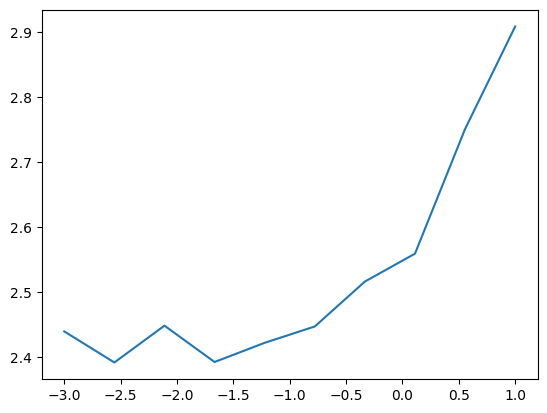

In [161]:
vali = []
lossi = []
for re in regularization_e:
    for i in range(2000):
        W.grad = None

        batchix = torch.randint(0, Xtr.shape[0], (batch_size,))

        Xb = Xtr[batchix]
        Yb = Ytr[batchix]

        logits = W[Xb]
        assert logits.shape == (batch_size, num_letters)

        loss = F.cross_entropy(logits, Yb) + 0.01 * (W**2).mean()

        if i % 100 == 99:
            print(f"Iteration {i} Loss: {loss}")
        
        loss.backward()

        lr = 50 if i < 5000 else 5
        W.data += -lr * W.grad

    # evaluate the model
    logits = W[Xdev]

    dev_loss = F.cross_entropy(logits, Ydev)
    lossi.append(dev_loss.data)
    vali.append(re)

plt.plot(vali, lossi)
    

In [148]:
# evaluate the model
logits = W[Xdev]

dev_loss = F.cross_entropy(logits, Ydev)
print(dev_loss)


tensor(2.2499, grad_fn=<NllLossBackward0>)


The training loop took a few tries to get right.

It took me a long time to figure out how to index into the predictions of the network `ypred` with the expected outputs `ys`. `ypred[ys]` by itself didn't work. 

But `ypred[torch.arange(len(ys)), ys]` did work. I tried it on a small toy example, before running it on the full dataset.

I also got the loss function wrong on the first try.

`ypred` is the predicted probability of the correct letter.

I thought that since I needed `ypred` to equal 1, the loss function for each example should be:

$$ \text{Loss for one example} = 1 - \text{ypred} $$

and then for all examples it should be:

$$ \text{Loss for all examples} = \sum_{\text{over all examples}}{\log (1 - \text{ypred})} $$

But it turns out the second statement is wrong. If `ypred` equals 1, we'll end up taking $\log 0$ for each example, which is $-\infty$.

Instead, the correct loss functions are as follows:

$$ \text{Loss for one example} = -\log \text{ypred} $$

$$ \text{Loss for all examples} = \sum_{\text{over all examples}}{-\log \text{ypred}} $$

This gives us a loss of 0 when the results are perfect, and a positive loss otherwise.


## Sampling words from our model

In [132]:
g = torch.Generator().manual_seed(2147483647 + 1)

for i in range(10):
    letters = '..'

    word = ''

    while True:
        predxenc = F.one_hot(torch.tensor([lltoi[letters]]), num_classes=num_letters * num_letters).float()

        logits = predxenc @ W
        assert logits.shape == (1, num_letters)
        probs = logits.softmax(dim=1)
        np.testing.assert_almost_equal(probs[0].sum().item(), 1, decimal=3)

        next_letter_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
        letter = itol[next_letter_ix.item()]

        if letter == '.':
            break

        word += letter
        letters = letters[1:] + letter
    print(word)

emackeni
amillah
saddiso
ikarana
hi
penaliann
faing
nali
lah
amaylislyn


In [18]:
W2 = W.detach().numpy()
plt.figure(figsize=(32, 16 * 16))
# plt.imshow(P, cmap='Blues')

for yy, row in enumerate(W2):
    for x, val in enumerate(row):
        plt.text(x, yy, f"{itoll[yy] + itol[x]}", va='center', ha='center')



ValueError: Image size of 64548x14350386 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 3200x25600 with 1 Axes>